# Aerial Semantic segmentation

This notebook is originated from: https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch

# Import Libraries

In [ ]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing

In [2]:
# Download the dataset and indicate the path of the dataset
# https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset

IMAGE_PATH = '/home/hrl_gpu_1/dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '/home/hrl_gpu_1/dataset/dataset/semantic_drone_dataset/label_images_semantic/'
os.path.exists(IMAGE_PATH)

True

In [3]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [4]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


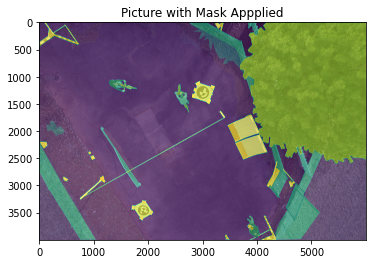

In [5]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataset

In [6]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

# Model

# Training

In [7]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [6]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [5]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [11]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [12]:
## Docs: https://smp.readthedocs.io/en/latest/models.html#id2

# model = smp.Unet('efficientnet-b0', \
#                  encoder_weights='imagenet', \
#                  classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
model = smp.DeepLabV3Plus('efficientnet-b0', \
                 encoder_weights='imagenet', \
                 classes=23, activation=None, encoder_depth=5, decoder_channels=128)
# model = smp.FPN('efficientnet-b0', \
#                  encoder_weights='imagenet', \
#                  classes=23, activation=None)

max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)
torch.save(model, 'UnetPlus-efficientnet.pt')

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.068 
Epoch:1/15.. Train Loss: 2.479.. Val Loss: 1.068.. Train mIoU:0.094.. Val mIoU: 0.200.. Train Acc:0.453.. Val Acc:0.697.. Time: 3.97m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.068 >> 0.787 
Epoch:2/15.. Train Loss: 1.221.. Val Loss: 0.787.. Train mIoU:0.209.. Val mIoU: 0.294.. Train Acc:0.665.. Val Acc:0.766.. Time: 3.93m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 1.068.. Val Loss: 0.852.. Train mIoU:0.266.. Val mIoU: 0.294.. Train Acc:0.698.. Val Acc:0.758.. Time: 3.95m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.852 >> 0.609 
Epoch:4/15.. Train Loss: 0.922.. Val Loss: 0.609.. Train mIoU:0.316.. Val mIoU: 0.391.. Train Acc:0.738.. Val Acc:0.820.. Time: 3.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.609 >> 0.560 
saving model...
Epoch:5/15.. Train Loss: 0.744.. Val Loss: 0.560.. Train mIoU:0.351.. Val mIoU: 0.408.. Train Acc:0.777.. Val Acc:0.835.. Time: 3.95m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.560 >> 0.498 
Epoch:6/15.. Train Loss: 0.613.. Val Loss: 0.498.. Train mIoU:0.392.. Val mIoU: 0.412.. Train Acc:0.815.. Val Acc:0.850.. Time: 3.98m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.498 >> 0.464 
Epoch:7/15.. Train Loss: 0.544.. Val Loss: 0.464.. Train mIoU:0.429.. Val mIoU: 0.452.. Train Acc:0.836.. Val Acc:0.858.. Time: 3.97m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/15.. Train Loss: 0.502.. Val Loss: 0.521.. Train mIoU:0.442.. Val mIoU: 0.435.. Train Acc:0.846.. Val Acc:0.847.. Time: 3.97m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.521 >> 0.406 
Epoch:9/15.. Train Loss: 0.519.. Val Loss: 0.406.. Train mIoU:0.441.. Val mIoU: 0.492.. Train Acc:0.841.. Val Acc:0.876.. Time: 3.96m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.406 >> 0.405 
Epoch:10/15.. Train Loss: 0.453.. Val Loss: 0.405.. Train mIoU:0.465.. Val mIoU: 0.503.. Train Acc:0.859.. Val Acc:0.881.. Time: 3.96m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.405 >> 0.375 
saving model...
Epoch:11/15.. Train Loss: 0.404.. Val Loss: 0.375.. Train mIoU:0.488.. Val mIoU: 0.501.. Train Acc:0.874.. Val Acc:0.885.. Time: 3.96m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.375 >> 0.363 
Epoch:12/15.. Train Loss: 0.380.. Val Loss: 0.363.. Train mIoU:0.501.. Val mIoU: 0.518.. Train Acc:0.881.. Val Acc:0.888.. Time: 3.96m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.363 >> 0.358 
Epoch:13/15.. Train Loss: 0.364.. Val Loss: 0.358.. Train mIoU:0.506.. Val mIoU: 0.522.. Train Acc:0.884.. Val Acc:0.891.. Time: 3.96m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.358 >> 0.356 
Epoch:14/15.. Train Loss: 0.348.. Val Loss: 0.356.. Train mIoU:0.520.. Val mIoU: 0.518.. Train Acc:0.890.. Val Acc:0.891.. Time: 3.97m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:15/15.. Train Loss: 0.346.. Val Loss: 0.363.. Train mIoU:0.521.. Val mIoU: 0.523.. Train Acc:0.891.. Val Acc:0.889.. Time: 3.97m
Total time: 59.40 m


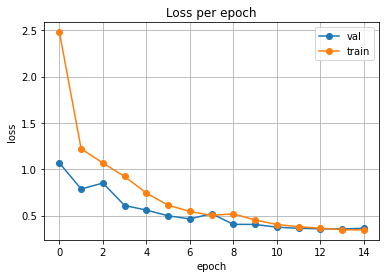

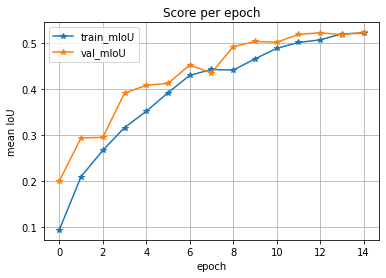

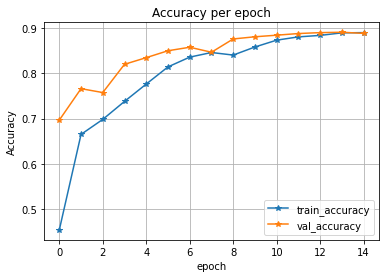

In [13]:
# with mobilenet
plot_loss(history)
plot_score(history)
plot_acc(history)

In [82]:
torch.cuda.empty_cache()

# Evaluation

In [25]:
# load a saved checkpoint model
model = torch.load('DeepLabV3Plus-efficientnet.pt')
# model = torch.load('Unet-efficientnet.pt')
# model = torch.load('fcn-efficientnet.pt')
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [9]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

## Result

In [10]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [11]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [12]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
        return score_iou

In [13]:
mob_miou = miou_score(model, test_set)
print(f'Test Set with {len(mob_miou)} datas: mIoU', np.mean(mob_miou))

  0%|          | 0/40 [00:00<?, ?it/s]

Test Set with 1 datas: mIoU 0.5776659494610342


In [14]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [15]:
model.eval()
mob_acc = pixel_acc(model, test_set)
print('Test Set Pixel Accuracy', np.mean(mob_acc))

  0%|          | 0/40 [00:00<?, ?it/s]

Test Set Pixel Accuracy 0.8940379390010127


(416, 608, 3)
torch.Size([416, 608])


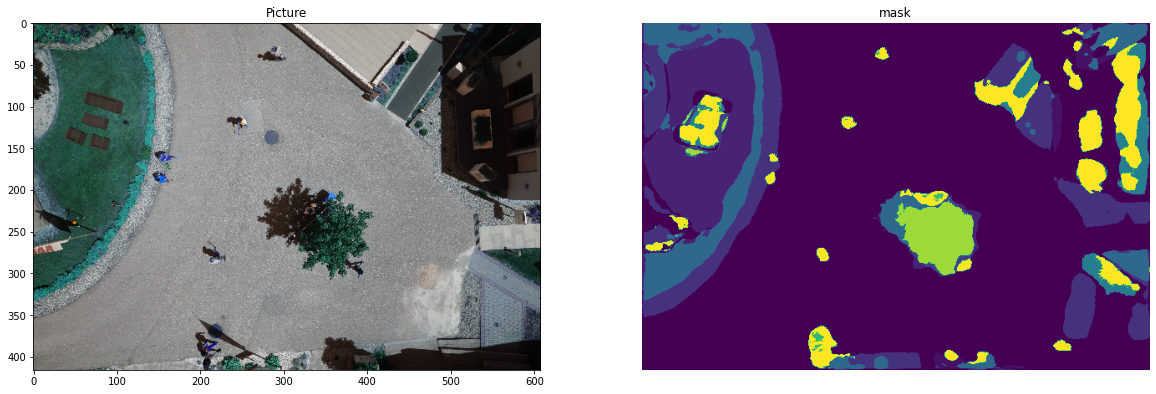

In [26]:
# img = cv2.imread("/home/hrl_gpu_1/Downloads/test_aerial.jpg")

# img = cv2.imread("/home/hrl_gpu_1/dataset/dataset/semantic_drone_dataset/original_images/004.jpg")
img = cv2.imread("/home/hrl_gpu_1/dataset/dataset/semantic_drone_dataset/original_images/002.jpg")
h, w, c = img.shape
img = cv2.resize(img, (608, 416))
print(img.shape)

def predict_image(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)       
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

pred_mask = predict_image(model, img)
print(pred_mask.shape)

# plotting
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Picture')

ax2.imshow(pred_mask)
ax2.set_title('mask')
ax2.set_axis_off()


unlabeled paved-area dirt grass gravel water rocks pool vegetation roof wall window 
door fence fence-pole person dog car bicycle tree bald-tree ar-marker obstacle conflicting 

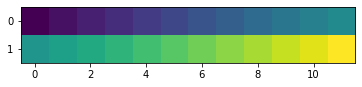

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']

for x in range(0, 12):
    print(labels[x], end =" ")
ax = plt.subplot()
im = ax.imshow(np.arange(24).reshape((2, 12)))
# print(np.arange(20).reshape((2, 10)))
print('')
for x in range(12, 24):
    print(labels[x], end =" ")


In [30]:
import time
start = time.time()
pred_mask = predict_image(model, img)
print(time.time() - start )

0.031461477279663086


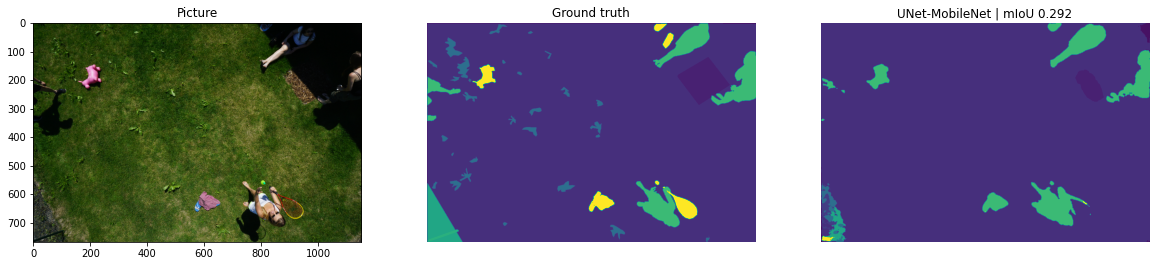

In [37]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

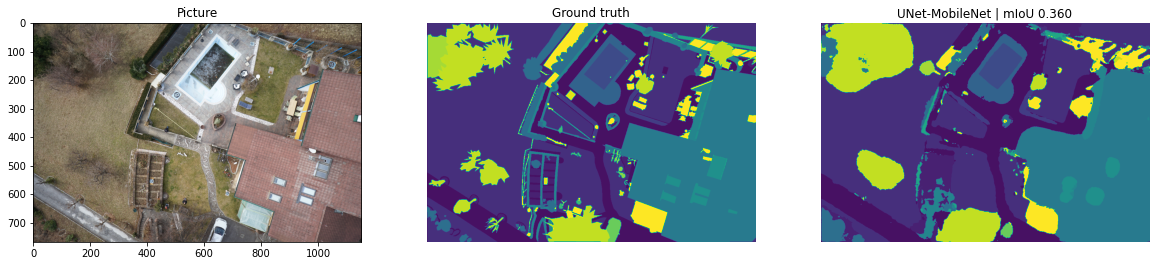

In [38]:
image2, mask2 = test_set[13]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

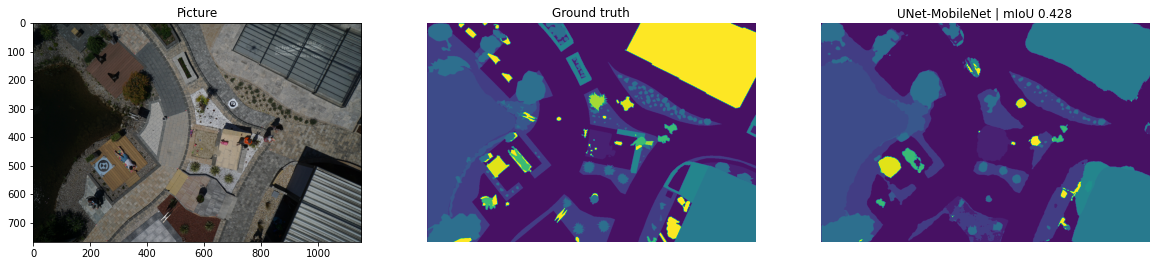

In [39]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [84]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

dump_tensors()

Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 32 × 3 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 32 × 32 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 64 × 32 × 3 × 3
Parameter: GPU pinned 512 × 256 × 1 × 1
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 64 × 64 × 1 × 1
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 256 × 64 × 1 × 1
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 128 × 32 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 32 × 64 × 1 × 1
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 128 × 32 × 1 × 1
Parameter: GPU pinned 128
Parameter: GPU pinned 256 × 64 × 1 × 1
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 128 × 256 × 1 × 1
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU

/home/hrl_gpu_1/.local/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:181: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Parameter: GPU pinned 32 × 3 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 32 × 1 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 8 × 32 × 1 × 1
Parameter: GPU pinned 8
Parameter: GPU pinned 32 × 8 × 1 × 1
Parameter: GPU pinned 32
Parameter: GPU pinned 16 × 32 × 1 × 1
Parameter: GPU pinned 16
Parameter: GPU pinned 16
Parameter: GPU pinned 96 × 16 × 1 × 1
Parameter: GPU pinned 96
Parameter: GPU pinned 96
Parameter: GPU pinned 96 × 1 × 3 × 3
Parameter: GPU pinned 96
Parameter: GPU pinned 96
Parameter: GPU pinned 4 × 96 × 1 × 1
Parameter: GPU pinned 4
Parameter: GPU pinned 96 × 4 × 1 × 1
Parameter: GPU pinned 96
Parameter: GPU pinned 24 × 96 × 1 × 1
Parameter: GPU pinned 24
Parameter: GPU pinned 24
Parameter: GPU pinned 144 × 24 × 1 × 1
Parameter: GPU pinned 144
Parameter: GPU pinned 144
Parameter: GPU pinned 144 × 1 × 3 × 3
Parameter: GPU pinned 6 × 144 × 1 × 1
Parameter: GPU pinned 6
Parameter: GPU pinned 144 × 6 × 1 × 1


Parameter: GPU pinned 512 × 512 × 3 × 3
Parameter: GPU pinned 512
Parameter: GPU pinned 512 × 512 × 3 × 3
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 512 × 512 × 3 × 3
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 128 × 768 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 64 × 384 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 64 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 32 × 192 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 32 × 32 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 16 × 32 × 3 × 3
Parameter: GPU pinned 16
Parameter: GPU pinned 16
Parameter: GPU pinned 16 × 16 × 3 × 3
Parameter: GPU pinned 16
Parameter: GPU pinned 16
Tensor: GPU pinned 512
Tensor: GPU p

Tensor: GPU pinned 10 × 240 × 1 × 1
Tensor: GPU pinned 10
Tensor: GPU pinned 10
Tensor: GPU pinned 240 × 10 × 1 × 1
Tensor: GPU pinned 240 × 10 × 1 × 1
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 40 × 240 × 1 × 1
Tensor: GPU pinned 40 × 240 × 1 × 1
Tensor: GPU pinned 40
Tensor: GPU pinned 40
Tensor: GPU pinned 40
Tensor: GPU pinned 40
Tensor: GPU pinned 240 × 40 × 1 × 1
Tensor: GPU pinned 240 × 40 × 1 × 1
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 240 × 1 × 3 × 3
Tensor: GPU pinned 240 × 1 × 3 × 3
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 10 × 240 × 1 × 1
Tensor: GPU pinned 10 × 240 × 1 × 1
Tensor: GPU pinned 10
Tensor: GPU pinned 10
Tensor: GPU pinned 240 × 10 × 1 × 1
Tensor: GPU pinned 240 × 10 × 1 × 1
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 80 × 240 × 1 × 1
Tensor: GPU pinned 80 × 240 × 1 × 1
Tensor: GP